In [1]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import numpy as np
from ipywidgets import interact, IntSlider
from constants import region_map, recessions, state_abbreviations
from fdic_data import get_deposit_data, get_failure_data, get_data

### Examining Bank Failure Data

I pulled the data from https://banks.data.fdic.gov/docs/#/.


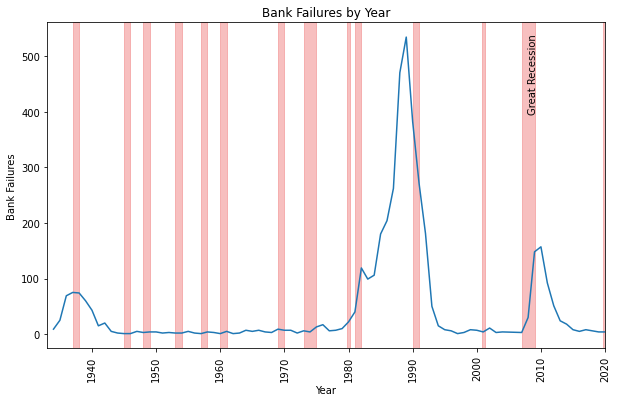

In [2]:
failure_df = get_data("data/failures.csv", get_failure_data)

# Turn the year column into an integer
failure_df["FAILYR"] = failure_df["FAILYR"].astype(int)

# important columns: FAILYR
failure_counts_by_year = failure_df.groupby("FAILYR").count().max(axis=1)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_counts_by_year.index, failure_counts_by_year.values)

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("Bank Failures")
plt.title("Bank Failures by Year")

# shade specific time periods
for start, end in recessions:
    plt.axvspan(start, end, color="lightcoral", alpha=0.5)

# set the x-axis limits
plt.xlim(1933, 2020)

# rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# add some annotations
plt.text(2008, 400, "Great Recession", fontsize=10, rotation=90)

# save the plot to a file
plt.savefig("plots/bank_failures_by_year_recessions_shaded.png")

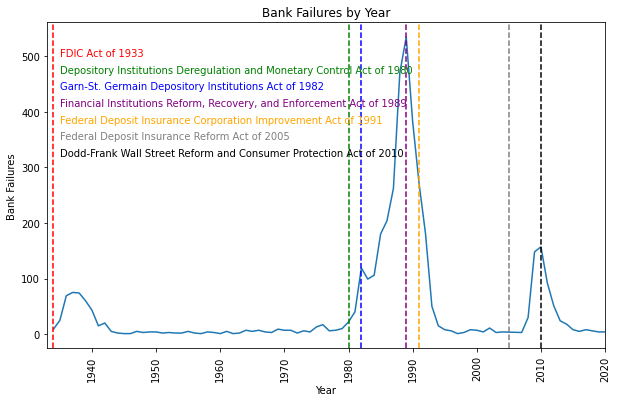

In [3]:
# major reforms
reforms ={
    1934: "FDIC Act of 1933",
    1980: "Depository Institutions Deregulation and Monetary Control Act of 1980",
    1982: "Garn-St. Germain Depository Institutions Act of 1982",
    1989: "Financial Institutions Reform, Recovery, and Enforcement Act of 1989",
    1991: "Federal Deposit Insurance Corporation Improvement Act of 1991",
    2005: "Federal Deposit Insurance Reform Act of 2005",
    2010: "Dodd-Frank Wall Street Reform and Consumer Protection Act of 2010",
}
my_colors = ['red', 'green', 'blue', 'purple', 'orange', 'gray', 'black']


# create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_counts_by_year.index, failure_counts_by_year.values)

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("Bank Failures")
plt.title("Bank Failures by Year")

# set the x-axis limits
plt.xlim(1933, 2020)

# rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# add some annotations
for i, (reform_year, reform_title) in enumerate(reforms.items()):
    plt.axvline(reform_year, color=my_colors[i], linestyle="dashed")
    plt.text(1935, 500 - 30 * i, reform_title, fontsize=10, color = my_colors[i])

# save the plot to a file
plt.savefig("plots/bank_failures_by_year_regulations.png")

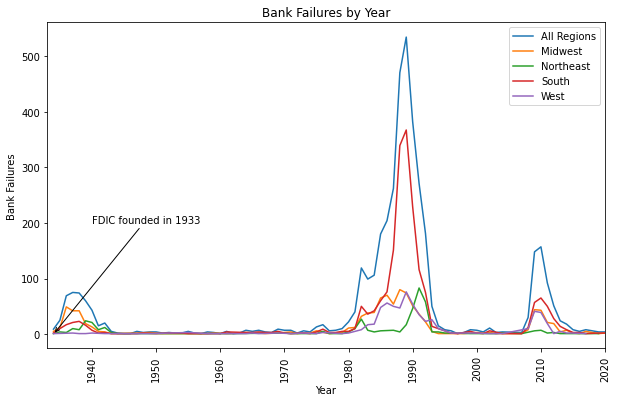

In [4]:
failure_df["REGION"] = failure_df["PSTALP"].map(region_map)

failure_counts_by_year_by_state = (
    failure_df.groupby(["FAILYR", "REGION"]).count().max(axis=1)
)

# filter to only Region = "South"
regions = failure_counts_by_year_by_state.index.get_level_values(
    "REGION").unique()

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(failure_counts_by_year.index, failure_counts_by_year.values)

for region in regions:
    region_counts = failure_counts_by_year_by_state.loc[
        failure_counts_by_year_by_state.index.get_level_values(
            "REGION") == region
    ]
    plt.plot([year for year, _ in region_counts.index], region_counts.values)

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("Bank Failures")
plt.title("Bank Failures by Year")

# set the x-axis limits
plt.xlim(1933, 2020)

# rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# add some annotations
# plt.text(2008, 400, "Great Recession", fontsize=10, rotation=90)
plt.annotate(
    "FDIC founded in 1933",
    xy=(1934, 0),
    xytext=(1940, 200),
    fontsize=10,
    arrowprops=dict(facecolor="black", arrowstyle="->"),
)

# add a legend
plt.legend(["All Regions", *regions])

# save the plot to a file
plt.savefig("plots/bank_failures_by_year_regions.png")

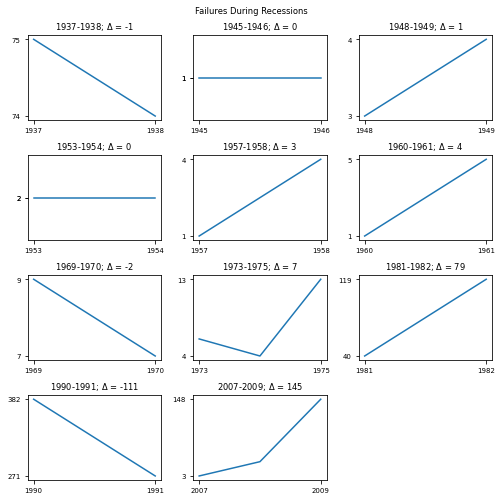

In [5]:
# Let's create a subplot with bank failures but in the recession years
recessions_to_plot = [(start, end) for start, end in recessions if end - start > 0.5]

# create the subplots and figures
plt.rc('font', size=7)
fig, axes = plt.subplots(4, 3, figsize=(7, 7))

# iterate over the axes and recessions
for ax, (start, end) in zip(axes.flatten(), recessions_to_plot):
    filter = failure_counts_by_year.index.isin(list(range(start, end + 1)))
    x = failure_counts_by_year[filter].index
    y = failure_counts_by_year[filter].values
    ax.plot(x, y)

    # Set the x and y tick locations to the minimum and maximum values
    ax.set_xticks([min(x), max(x)])
    ax.set_yticks([min(y), max(y)])

    # Set the x and y tick labels to the minimum and maximum values
    ax.set_xticklabels([min(x), max(x)])
    ax.set_yticklabels([min(y), max(y)])

    delta = r"$\Delta$"

    ax.set_title(f"{start}-{end}; {delta} = {y[-1] - y[0]}")


# remove the blank plot
axes.flatten()[11].set_axis_off()

# Set a title for the entire figure
fig.suptitle("Failures During Recessions")

# Adjust the spacing between subplots
fig.tight_layout()

# save the plot to a file
plt.savefig("plots/bank_failures_by_year_recession.png")

### Examining the FDIC Deposit Data


In [6]:
# deposits_df = get_data("data/deposits.csv", get_deposit_data)

# read in the four dataframes 
deposits_df_1 = pd.read_csv("data/deposits_1.csv")
deposits_df_2 = pd.read_csv("data/deposits_2.csv")
deposits_df_3 = pd.read_csv("data/deposits_3.csv")
deposits_df_4 = pd.read_csv("data/deposits_4.csv")

# combine the four dataframes into one
deposits_df = pd.concat([deposits_df_1, deposits_df_2, deposits_df_3, deposits_df_4])

deposits_df["REGION"] = deposits_df["STALPBR"].map(region_map)


### Bank Failure Rate Over Time

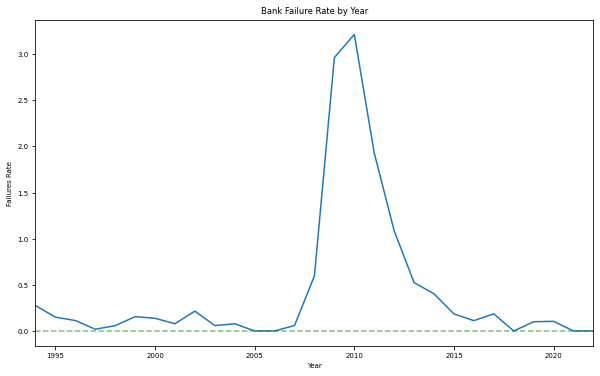

In [7]:
num_banks_by_year = deposits_df.groupby("YEAR")['RSSDHCR'].nunique()
num_banks_by_year_df = num_banks_by_year.reset_index()
num_banks_by_year_df.columns = ['YEAR', 'NUM_BANKS']

failure_count_by_year_df = failure_counts_by_year.reset_index()
failure_count_by_year_df.columns = ['YEAR', 'NUM_FAILURES']

bank_and_failure_counts = num_banks_by_year_df.merge(failure_count_by_year_df, on='YEAR', how='left')
bank_and_failure_counts.fillna(0.0, inplace=True)

bank_and_failure_counts['Failure Rate'] = 100.0*bank_and_failure_counts['NUM_FAILURES'] / bank_and_failure_counts['NUM_BANKS']

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(bank_and_failure_counts['YEAR'], bank_and_failure_counts['Failure Rate'])

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("Failures Rate")
plt.title("Bank Failure Rate by Year")


# set axis limits
plt.xlim(1994, 2022)

# add a hoirzontal line at 0
plt.axhline(0, color="green", alpha=0.5, linestyle="--")

# save the plot to a file
plt.savefig("plots/bank_failure_rate_by_year.png")

### HHI Over Time

In [8]:
def compute_hhi(sub_df):
    numer = sub_df.groupby("NAMEFULL")["DEPSUMBR"].sum()
    denom = sub_df["DEPSUMBR"].sum()
    return ((numer / denom) ** 2).sum() * 10_000

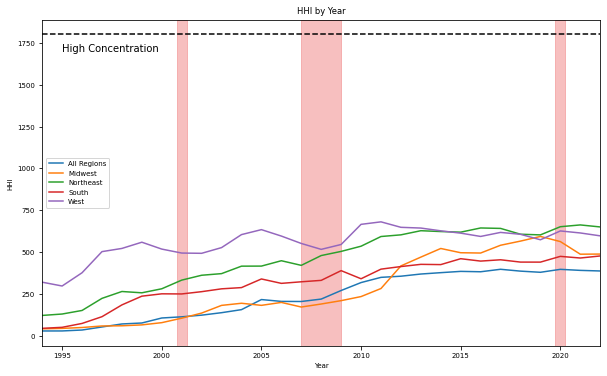

In [9]:
# compute HHI for the whole country
hhi = deposits_df.groupby("YEAR").apply(compute_hhi)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(hhi.index, hhi.values)

# plot for every region
for region in regions:
    region_hhi = (
        deposits_df.loc[deposits_df["REGION"] == region]
        .groupby("YEAR")
        .apply(compute_hhi)
    )
    plt.plot(region_hhi.index, region_hhi.values)

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("HHI")
plt.title("HHI by Year")

# shade specific time periods
for start, end in recessions:
    plt.axvspan(start, end, color="lightcoral", alpha=0.5)

# set the x-axis limits
plt.xlim(1994, 2022)

# legend
plt.legend(["All Regions", *regions])

# add a horizontal line at 1800 for high concentration
plt.axhline(1800, color="black", linestyle="--")
plt.text(1995, 1700, "High Concentration", fontsize=10)

# save the plot to a file
plt.savefig("plots/hhi_by_year_regions.png")

### Time to make some maps!


In [10]:
# load the shapefile
states = gpd.read_file("data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

In [11]:
cmap = plt.cm.OrRd
norm = colors.Normalize(vmin=0, vmax=10000)


def create_geo_df(year):
    # filter to a year
    hhi = (
        deposits_df.query(f"YEAR=={year}")
        .groupby(["STALPBR"])
        .apply(compute_hhi)
        .reset_index()
    )
    hhi.columns = ["STALPBR", "HHI"]

    # merge the HHI data with the shapefile
    states_hhi = states.merge(hhi, left_on="STUSPS", right_on="STALPBR")

    # drop non continental states
    mainland_filter = "STUSPS not in ['AK', 'HI', 'PR', 'VI', 'GU', 'MP', 'AS']"
    return states_hhi.query(mainland_filter)


def plot_hhi(states_data, col="HHI", year=1994):
    # Create the plot
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set_aspect("equal")
    states_data.plot(
        column=col, cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", norm=norm
    )
    ax.axis("off")

    # Add a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, shrink=0.45, pad=0.1)

    # Set the title of the legend and the plot
    cbar.set_label("HHI")
    ax.set_title(f"HHI by State ({year})")


In [12]:
# Create an interactive slider with the years
slider = IntSlider(min=1994, max=2022, step=1, value=1994)


# Use the slider to update the map for the selected year
def update_map(year):
    data = create_geo_df(year)
    plot_hhi(data, year=year)

interact(update_map, year=slider)

interactive(children=(IntSlider(value=1994, description='year', max=2022, min=1994), Output()), _dom_classes=(…

<function __main__.update_map(year)>

In [ ]:
# create a folder with the maps so you can create a gif
for year in range(1994, 2023):   
    data = create_geo_df(year)
    plot_hhi(data, year=year)
    plt.savefig(f"plots/hhi_maps/hhi_{year}.png")

### Deposit Growth Over Time


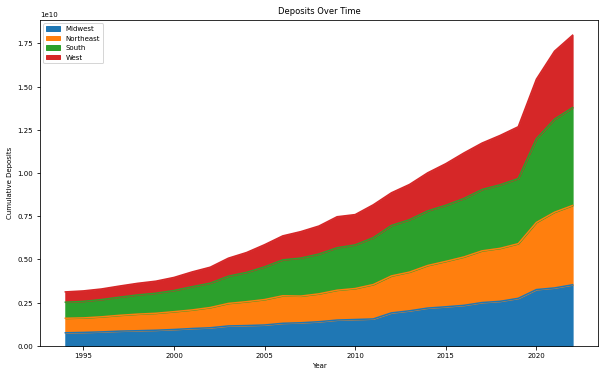

In [13]:
# Group by year and region and calculate the cumulative sum of sales
sales_by_region = (
    deposits_df.groupby(["YEAR", "REGION"])["DEPSUMBR"].sum()
)

# Create a pivot table to prepare data for plotting
pivot_sales = sales_by_region.reset_index().pivot(
    index="YEAR", columns="REGION", values="DEPSUMBR"
)

# Set the size of the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the cumulative sum of sales by region for each year with a different color
pivot_sales.plot.area(ax=ax, stacked=True)

# Set the title and axes labels
ax.set_title("Deposits Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative Deposits")

# Customize the Y-axis tick labels to display values in billions
# formatter = ticker.FuncFormatter(lambda x, pos: f"{x/1e9:.0f}")
# ax.yaxis.set_major_formatter(formatter)

# Customize the legend
ax.legend(loc="upper left")

# save the plot to a file
plt.savefig("plots/deposits_over_time.png")

### South Dakota Strangeness

It appears between 2003 and 2004, the amount of deposits went from 15,715,744,000 to 53,277,826,000.


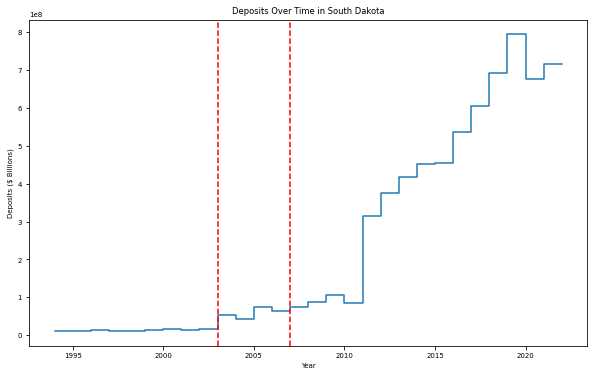

In [14]:
south_dakota = deposits_df.query("STALPBR == 'SD'")

# Group deposits over time in south dakota
south_dakota_deposits = south_dakota.groupby("YEAR")["DEPSUMBR"].sum()

# plot the deposits over time
fig, ax = plt.subplots(figsize=(10, 6))
plt.step(south_dakota_deposits.index, south_dakota_deposits.values)

# add a vertical line at 2003
plt.axvline(2003, color="red", linestyle="--")

# add a vertical line at 2007
plt.axvline(2007, color="red", linestyle="--")

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("Deposits ($ Billions)")
plt.title("Deposits Over Time in South Dakota")

# save the plot to a file
plt.savefig("plots/deposits_over_time_sd.png")

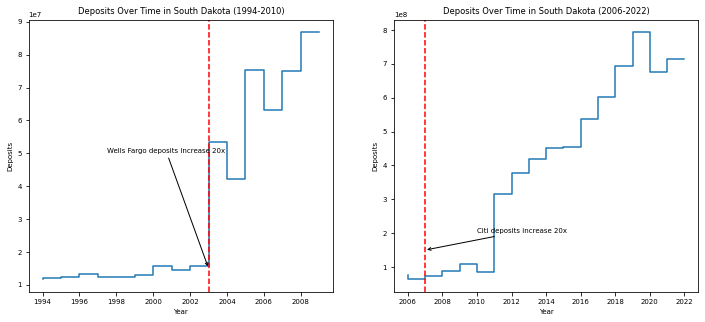

In [15]:
early_bump = list(range(1994, 2010))
later_bump = list(range(2006, 2023))

def plot_first_half(ax):
    ax.step(early_bump, south_dakota_deposits[early_bump])

    # add axis labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Deposits")
    ax.set_title("Deposits Over Time in South Dakota (1994-2010)")


    # add a vertical line at 2003
    ax.axvline(2003, color="red", linestyle="--")


    # add an annotation
    ax.annotate(
        "Wells Fargo deposits increase 20x",
        xy=(2003, 1.5e7),
        xytext=(1997.5, 5e7),
        arrowprops=dict(facecolor="black", arrowstyle="->"),
        wrap=True,
    )

def plot_second_half(ax):
    ax.step(later_bump, south_dakota_deposits[later_bump])

    # add axis labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Deposits")
    ax.set_title("Deposits Over Time in South Dakota (2006-2022)")

    # add a vertical line at 2007
    ax.axvline(2007, color="red", linestyle="--")

    # add an annotation
    ax.annotate(
        "Citi deposits increase 20x",
        xy=(2007, 1.5e8),
        xytext=(2010, 2e8),
        arrowprops=dict(facecolor="black", arrowstyle="->"),
        wrap=True,
    )

# plot the deposits over time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_first_half(axes[0])
plot_second_half(axes[1])

# save the plot to a file
plt.savefig("plots/deposits_over_time_sd_split.png")

/var/folders/0j/kgh6w5wn21110jzjf_z5vkj40000gn/T/ipykernel_79372/2205585147.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_dakota["Bank"] = south_dakota["NAMEBR"].copy().apply(


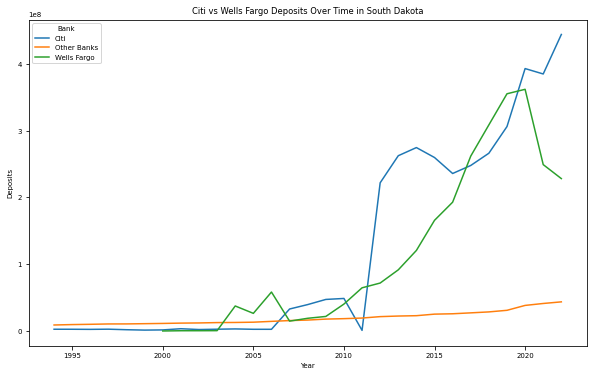

In [16]:
citi_wells_map = {
    "Citi": [
        "Citibank (South Dakota), N.A.",
        "Citibank, National Association",
        "Citibank (South Dakota) Baml Branch",
        "Citibank Usa, National Association",
        "Citibank Usa, National Association Branch",
    ],
    "Wells Fargo": [
        "Wells Fargo Bank, National Association",
        "Wells Fargo Financial Bank",
        "Wells Fargo Financial Bank Branch",
        "Www.Wellsfargo.Com",
        "Wells Fargo Bank South Dakota, Natio",
        "Wells Fargo Bank South Dakota, National Association",
    ],
}

south_dakota["Bank"] = south_dakota["NAMEBR"].copy().apply(
    lambda x: "Citi"
    if x in citi_wells_map["Citi"]
    else "Wells Fargo"
    if x in citi_wells_map["Wells Fargo"]
    else "Other Banks"
)

south_dakota_bank_composition = south_dakota.groupby(["YEAR", "Bank"])["DEPSUMBR"].sum()

# plot the deposits over time
fig, ax = plt.subplots(figsize=(10, 6))

# plot the deposits over time
south_dakota_bank_composition.unstack().plot(ax=ax)

# add axis labels and title
plt.xlabel("Year")
plt.ylabel("Deposits")
plt.title("Citi vs Wells Fargo Deposits Over Time in South Dakota")

# save the plot to a file
plt.savefig("plots/sd_wells_citi.png")